In [84]:
import sklearn
import sys
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib .pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils.extmath import density
from sklearn.tree import DecisionTreeRegressor
from time import time
print(f"Sklearn version: {sklearn.__version__}")
print(f"System version: {sys.version}")
print(f"Torch version: {torch.__version__}")
dataset = './Data/Flight_Ticket_Participant_Datasets/Data_Train.xlsx'


Sklearn version: 1.2.2
System version: 3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]
Torch version: 2.0.1


In [85]:
def preprocessing(dataframe:pd.DataFrame) -> pd.DataFrame:    
    dataframe.dropna(inplace = True)
    
    dataframe["Journey_day"] = pd.to_datetime(dataframe.Date_of_Journey, format="%d/%m/%Y").dt.day
    dataframe['Journey_month'] = pd.to_datetime(dataframe['Date_of_Journey'], format="%d/%m/%Y").dt.month
    dataframe.drop(['Date_of_Journey'], axis=1, inplace=True)
    
    dataframe['Dep_hour'] = pd.to_datetime(dataframe['Dep_Time']).dt.hour
    dataframe['Dep_min'] = pd.to_datetime(dataframe['Dep_Time']).dt.minute
    dataframe.drop(["Dep_Time"], axis=1, inplace=True)

    dataframe['Arrival_hour'] = pd.to_datetime(dataframe.Arrival_Time).dt.hour
    dataframe['Arrival_min'] = pd.to_datetime(dataframe.Arrival_Time).dt.minute
    dataframe.drop(['Arrival_Time'], axis=1, inplace=True)

    duration = list(dataframe['Duration'])
    for idx in range(len(duration)):
        if len(duration[idx].split())!=2:
            if "h" in duration[idx]:
                duration[idx] = duration[idx].strip()+" 0m"
            else:
                duration[idx] = "0h "+ duration[idx]
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split(sep="h")[0]))
        duration_mins.append(int(duration[i].split(sep="m")[0].split()[-1]))
    dataframe["Duration_hours"] = duration_hours
    dataframe["Duration_mins"] = duration_mins
    dataframe.drop(["Duration"], axis=1, inplace=True)

    # print(dataframe["Airline"].value_counts())

    Airlines = dataframe[['Airline']]
    Airlines = pd.get_dummies(Airlines, drop_first=True)

    Source = dataframe[['Source']]
    Source = pd.get_dummies(Source, drop_first=True)

    Destination = dataframe[['Destination']]
    Destination = pd.get_dummies(Destination, drop_first=True)

    dataframe.drop(["Route", "Additional_Info"], axis = 1, inplace = True)
    dataframe.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

    data_train = pd.concat([dataframe, Airlines, Source, Destination], axis = 1)
    data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)
    return data_train
def get_X_Y(dataset:pd.DataFrame) -> pd.DataFrame:
    X = dataset.loc[:, ['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
    y = dataset.iloc[:, 1]
    return X, y
def benchmark_models(clf, X_train, y_train, X_test, y_test, custom_name=False):
    print("_"*80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time()-t0
    print(f"Training time :{train_time:.3}s")

    t0 = time()
    pred =  clf.predict(X_test)
    test_time = time()-t0
    print(f"Testing time :{test_time:.3}s")

    print('MAE:', metrics.mean_absolute_error(y_test, y_pred=pred))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred=pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred=pred)))

    # accuracy = metrics.accuracy_score(y_true=y_test, y_pred=pred)
    # f1_score = metrics.f1_score(y_true=y_test, y_pred=pred, average='micro')
    # print(f"accuracy: {accuracy:.3}")
    # print(f"f1 score: {f1_score:.3}")
    
    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()
    
    clf_descr = clf.__class__.__name__

    return clf_descr, metrics.mean_squared_error(y_test, y_pred=pred), train_time, test_time

In [87]:
data_train = preprocessing(pd.read_excel(dataset))
X, y = get_X_Y(data_train)


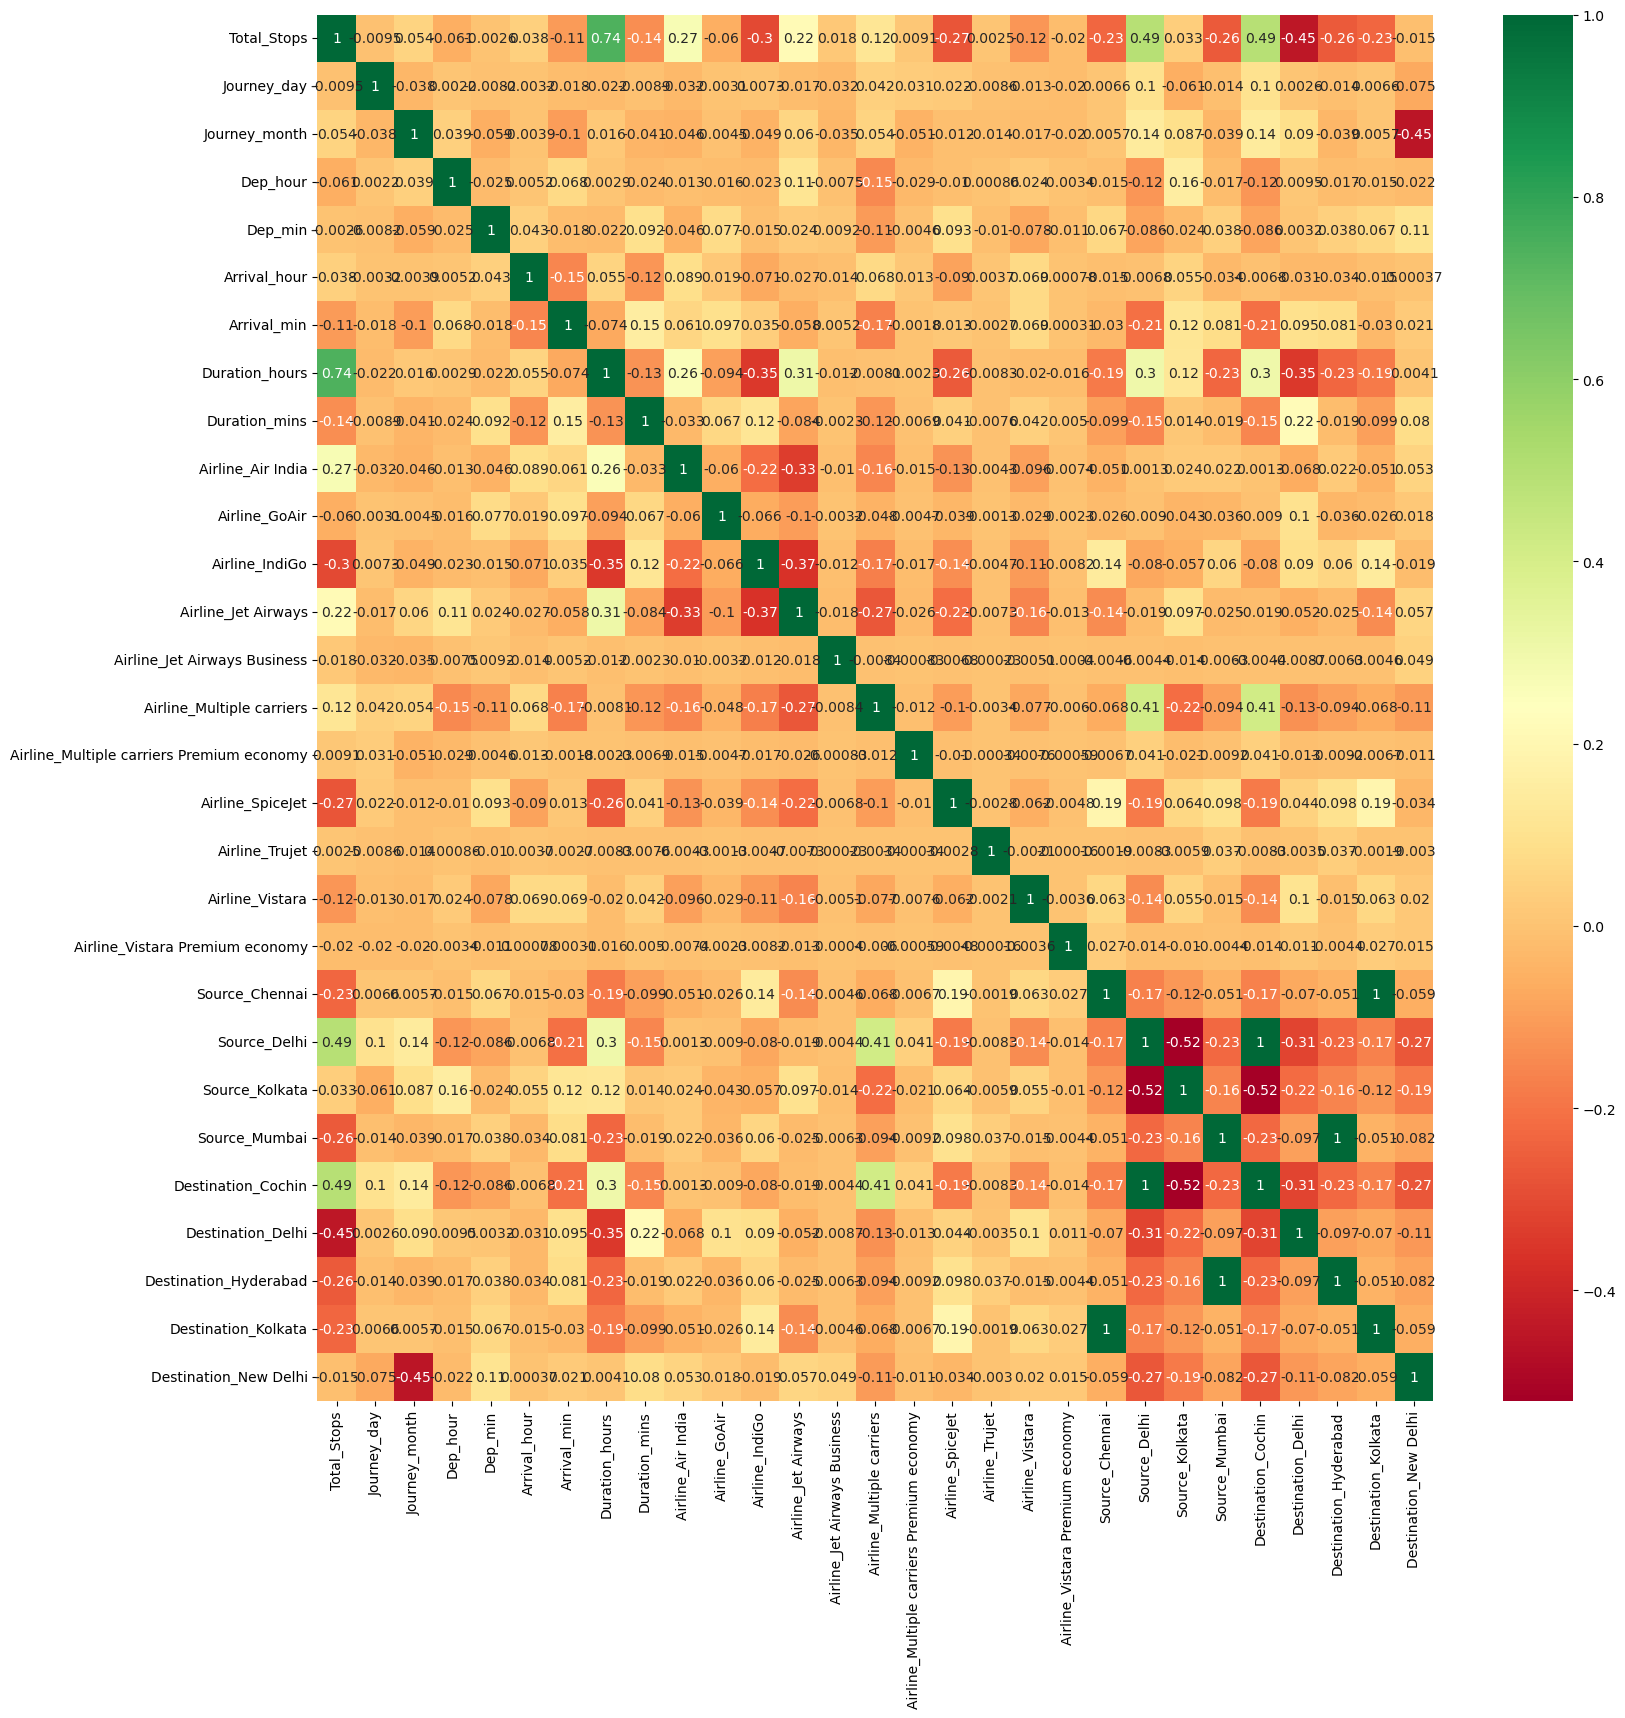

In [88]:
plt.figure(figsize = (18,18))
sns.heatmap(X.corr(), annot = True, cmap = "RdYlGn")
plt.show()

In [89]:
selection = ExtraTreesRegressor()
selection.fit(X, y)
print(selection.feature_importances_)

[2.06655157e-01 1.43659797e-01 5.33337993e-02 2.43353069e-02
 2.11531811e-02 2.74990001e-02 1.92237613e-02 1.47238195e-01
 1.74301132e-02 8.52368535e-03 1.58089500e-03 1.62704883e-02
 1.42636742e-01 6.77253516e-02 2.04741545e-02 8.75006475e-04
 2.53453086e-03 9.37531442e-05 4.94453347e-03 8.40578902e-05
 3.77373026e-04 8.94532991e-03 3.53278806e-03 6.87137490e-03
 8.88780103e-03 1.28400875e-02 6.88007194e-03 5.33997483e-04
 2.48596672e-02]


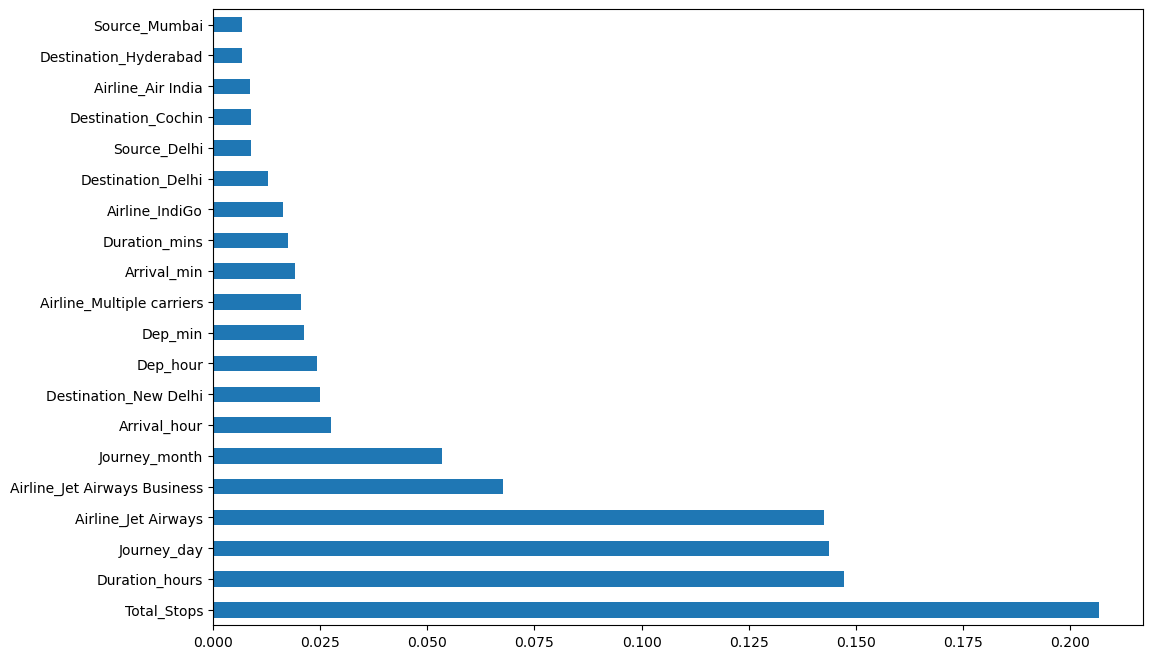

In [90]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
result = []
for clf, name in( 
    (RandomForestRegressor(), "RandomForestRegressor"), 
    (DecisionTreeRegressor(), "DecisionTreeRegressor"),
    (HistGradientBoostingRegressor(), "HistGradientBoostingRegressor"),
    ):
    print("="*80)
    print(name)
    result.append(benchmark_models(clf, X_train, y_train, X_test, y_test))

RandomForestRegressor
________________________________________________________________________________
Training: 
RandomForestRegressor()
Training time :1.51s
Testing time :0.0322s
MAE: 1178.2460888219043
MSE: 4368879.004456936
RMSE: 2090.1863563943134
DecisionTreeRegressor
________________________________________________________________________________
Training: 
DecisionTreeRegressor()
Training time :0.0219s
Testing time :0.00115s
MAE: 1323.188309156138
MSE: 5760745.787353637
RMSE: 2400.1553673363806
HistGradientBoostingRegressor
________________________________________________________________________________
Training: 
HistGradientBoostingRegressor()
Training time :0.236s
Testing time :0.00441s
MAE: 1243.947582322343
MSE: 3761027.2948531723
RMSE: 1939.336818310108


In [111]:
model = HistGradientBoostingRegressor()
test = './Data/Flight_Ticket_Participant_Datasets/Test_set.xlsx'
test_dataset = preprocessing(pd.read_excel(test))
# column is missing in test_dataset to adding it
test_dataset.insert(loc=17, column='Airline_Trujet', value=[0]*len(test_dataset))
print(X.shape, y.shape, test_dataset.shape)

(10682, 29) (10682,) (2671, 29)


In [112]:
model.fit(X,y)
prediction = model.predict(test_dataset)

In [115]:
df = pd.DataFrame(prediction, columns=['Price'])
df.to_csv('submission.csv')